# my own created a stock market prediction 

In [76]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
import pandas as pd
import numpy as np

### **Part 1**: Transforming the date for later predictions

In [77]:
def get_windowed_df(stock_name, period='max', start=None, end=None):
    big_data = yf.Ticker(stock_name)

    stock_df = big_data.history(period=period, start=start, end=end).copy()
    columns = stock_df.columns

    # Discart unsefull columns
    stock_df.drop(columns=columns.difference(['Close']), inplace=True)
    stock_df.rename(columns={'Close':'Target'}, inplace=True)
    stock_df['Date'] =  stock_df.index.strftime('%Y-%m-%d')
    stock_df.reset_index(inplace=True, drop=True)
    # get target columns by Close values previusly dates
    stock_df['Target_1'] = stock_df['Target'].shift(1)
    stock_df['Target_2'] = stock_df['Target'].shift(2)
    stock_df['Target_3'] = stock_df['Target'].shift(3)
    stock_df = stock_df[['Date', 'Target_1', 'Target_2', 'Target_3', 'Target']]
    stock_df.dropna(inplace=True)

    return stock_df


First, we create storaged the close values in target columns with the previosly 3 days before the current day (target data)

In [78]:
windowed_df = get_windowed_df('ITUB4.SA', start=(datetime.now() - timedelta(days=366)).strftime('%Y-%m-%d'))
windowed_df


,Date,Target_1,Target_2,Target_3,Target
3,2023-01-17,24.419680,24.687084,24.811237,24.925837
4,2023-01-18,24.925837,24.419680,24.687084,25.374691
5,2023-01-19,25.374691,24.925837,24.419680,25.374691
6,2023-01-20,25.374691,25.374691,24.925837,24.925837
7,2023-01-23,24.925837,25.374691,25.374691,24.161825
...,...,...,...,...,...
244,2024-01-08,33.700001,32.930000,33.150002,33.340000
245,2024-01-09,33.340000,33.700001,32.930000,33.320000
246,2024-01-10,33.320000,33.340000,33.700001,33.290001
247,2024-01-11,33.290001,33.320000,33.340000,33.349998


after that, we transform the data into a numpy format and reshaped this in 3 variables 

In [79]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:,-1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)



In [80]:
print(dates.shape, X.shape, y.shape)

(246,) (246, 3, 1) (246,)


In [109]:
q_80 = int(len(dates) * 0.8) 
q_90 = int(len(dates) * 0.9) 

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

print(dates_train.shape, dates_val.shape, dates_test.shape)

(196,) (25,) (25,)


now, our data are structured with this features:

- **train set**: almost 10 months of close values considering the last data
- **validation set**: more than 1 months of close values considering the intermediable data
- **test set**: more than 1 month of close values considering the most actual data

after that we can visualize the transformed data for predictions

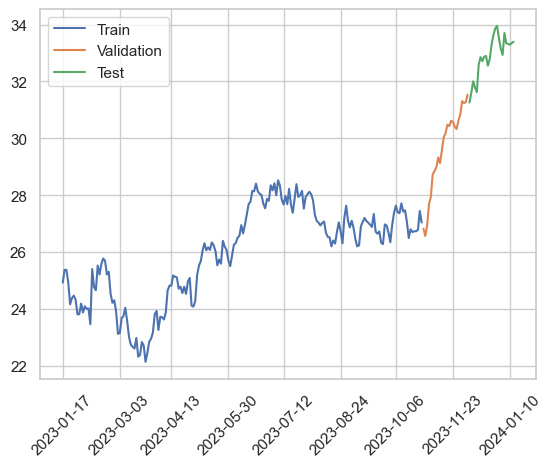

In [102]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
# Set major ticks to show only years
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=12))
plt.gca().tick_params(axis='x', rotation=45)

plt.show()

### **Part 2**: choosing the best model for predictions 

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [110]:
model = Sequential([
    layers.Input((3,1)),
    layers.LSTM(64,),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])
model.compile(
    loss='mse', 
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)


In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


7/7 [==============================] - 0s 3ms/step


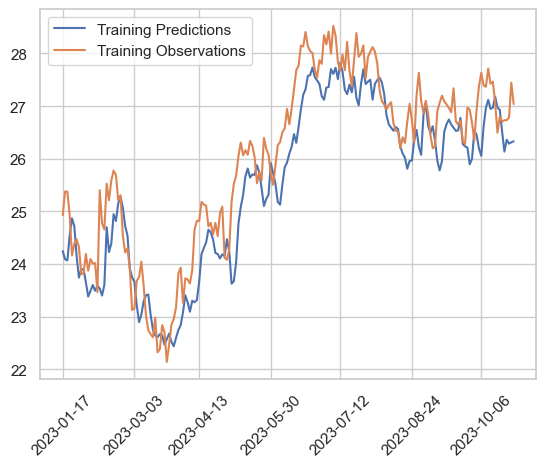

In [103]:

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)


# Set major ticks to show only years
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=12))
plt.gca().tick_params(axis='x', rotation=45)

plt.legend(['Training Predictions', 'Training Observations'])
plt.show()

1/1 [==============================] - 0s 86ms/step


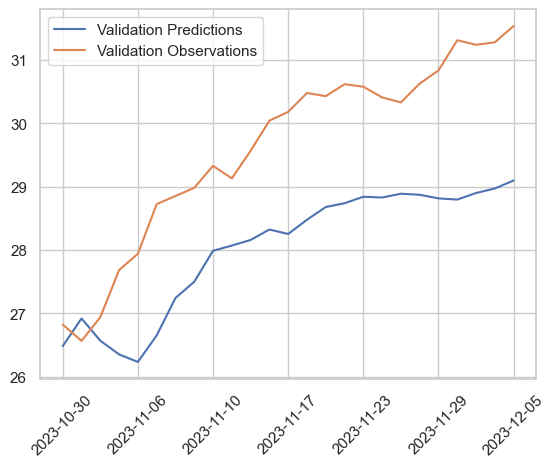

In [104]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=12))
plt.gca().tick_params(axis='x', rotation=45)

plt.show()

1/1 [==============================] - 0s 39ms/step


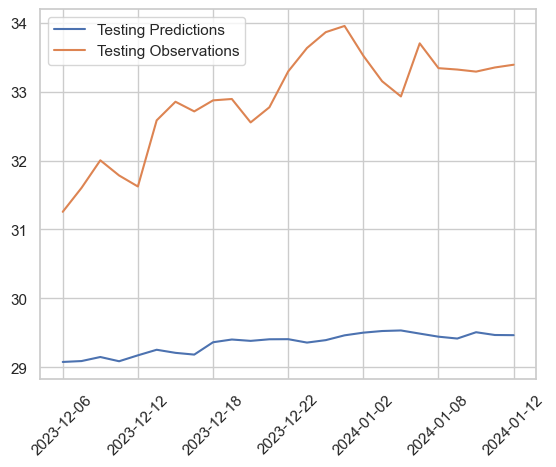

In [105]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=12))
plt.gca().tick_params(axis='x', rotation=45)

plt.show()

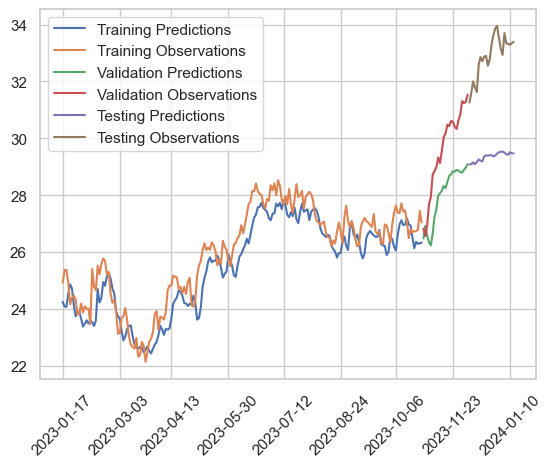

In [106]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=12))
plt.gca().tick_params(axis='x', rotation=45)



plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])